<a href="https://colab.research.google.com/github/Karthick47v2/speech-emotion-classifier/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import matplotlib.pyplot as plt

In [14]:
X_mfcc =np.load('drive/MyDrive/SER/X_mfcc.npy')
X_mel = np.load('drive/MyDrive/SER/X_mel.npy')
y = np.load('drive/MyDrive/SER/y.npy')

In [15]:
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X_mfcc, y_encoded, random_state=42, test_size=0.1)

In [17]:
x_train.shape

(2764, 13, 200)

In [18]:
n_rows = x_train.shape[1]
n_cols = x_train.shape[2]
n_channels = 1

x_train = x_train.reshape(x_train.shape[0], n_rows, n_cols, n_channels)
x_test = x_test.reshape(x_test.shape[0], n_rows, n_cols, n_channels)

In [71]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer="he_normal", input_shape=(n_rows, n_cols, n_channels), activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(filters=48, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.GlobalAveragePooling2D())

model.add(keras.layers.Dense(units=8, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=1e-3))

n_epochs = 200
batch_size = 128

# checkPoint

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(x_test, y_test), verbose=1)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 11, 198, 32)       320       
                                                                 
 batch_normalization_66 (Bat  (None, 11, 198, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 5, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 3, 97, 48)         13872     
                                                                 
 batch_normalization_67 (Bat  (None, 3, 97, 48)        192       
 chNormalization)                                                
                                                     

In [72]:
#95 82

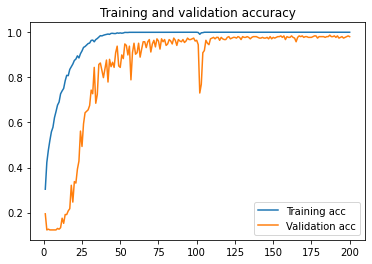

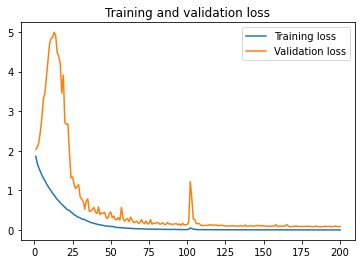

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()